# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа необходимо:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

2. А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Для ответа на каждый вопрос зададим уровень значимости $\alpha$ = 0.05

Данные содержат следующие столбцы:

1. *work_year* - Год, в котором была выплачена зарплата.
2. *experience_level* -Опыт работы на этой должности в течение года со следующими возможными значениями:
- EN — Entry-level/Junior;
- MI — Mid-level/Intermediate;
- SE — Senior-level/Expert;
- EX — Executive-level/Director
3. *employment_type* - тип трудоустройства для этой роли:
- PT — неполный рабочий день;
- FT — полный рабочий день;
- CT — контракт;
- FL — фриланс.
4. *job_title* - Роль, в которой соискатель работал в течение года.
5. *salary* - Общая выплаченная валовая сумма заработной платы.
6. *salary_currency* - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
7. *salary_in_usd* - 	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
8. *employee_residence* - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
9. *remote_ratio* - Общий объём работы, выполняемой удалённо. Возможные значения:
- 0 — удалённой работы нет (менее 20 %);
- 50 — частично удалённая работа;
- 100 — полностью удалённая работа (более 80 %).
10. *company_location* - 	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
11. *company_size* - Среднее количество людей, работавших в компании в течение года:
- S — менее 50 сотрудников (небольшая компания);
- M — от 50 до 250 сотрудников (средняя компания);
- L — более 250 сотрудников (крупная компания).

Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [192]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [193]:
data = pd.read_csv('C:/Users/Насим/Documents/GitHub/Pandas/data/ds_salaries.csv')

In [194]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [196]:
print(f'Количество дупликатов в датасете сосставляет {data[data.duplicated()].shape[0]} записей')

Количество дупликатов в датасете сосставляет 0 записей


Удалим неинформативный признак, являющийся копией индекса строки:

In [197]:
data.drop('Unnamed: 0', axis=1, inplace=True)

К категориальным признакам датасета относятся:
- experience_level (опыт работы) - *порядковый* 
- employment_type (тип трудоустройства) - *номинальный*
- job_title (название должности) - *номинальный*
- salary_currency (валюта получаемой заработной платы) - *номинальный*
- employee_residence (Основная страна проживания сотрудника) - *номинальный*
- remote_ratio (Общий объём работы, выполняемой удалённо) - номинально данный признак является числовым, однако учитывая, что там всего три значения, его можно отнести к категориальному признаку
- company_location (Страна главного офиса работодателя или филиала по контракту) - *номинальный*
- company_size (Среднее количество людей, работавших в компании в течение года) - *порядковый*

К числовым признакам датасета относятся:
- work_year (Год, в котором была выплачена зарплата)
- salary (Общая выплаченная валовая сумма заработной платы)
- salary_in_usd(Зарплата в долларах США)

In [198]:
#настроим формат просмотра вещественных чисел для большей понимаемости
pd.options.display.float_format = '{:20,.2f}'.format

#посмотрим описательную статистику
data.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,607.00,607,607,607,607.00,607,607.00,607,607.00,607,607
unique,NaN,4,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,SE,FT,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,280,588,143,NaN,398,NaN,332,NaN,355,326
mean,"2,021.41",NaN,NaN,NaN,"324,000.06",NaN,"112,297.87",NaN,70.92,NaN,NaN
std,0.69,NaN,NaN,NaN,"1,544,357.49",NaN,"70,957.26",NaN,40.71,NaN,NaN
min,"2,020.00",NaN,NaN,NaN,"4,000.00",NaN,"2,859.00",NaN,0.00,NaN,NaN
25%,"2,021.00",NaN,NaN,NaN,"70,000.00",NaN,"62,726.00",NaN,50.00,NaN,NaN
50%,"2,022.00",NaN,NaN,NaN,"115,000.00",NaN,"101,570.00",NaN,100.00,NaN,NaN
75%,"2,022.00",NaN,NaN,NaN,"165,000.00",NaN,"150,000.00",NaN,100.00,NaN,NaN


- *по призаку work_year (год) данные представлены в трех годах (2020,2021,2022)*
- *по признаку experience_level (опыт работы) 4 уникальных значения, модальное значение - SE (Senior-level/Expert)*
- *по признаку employment_type(тип трудоуствройства) 4 уникальных значений, модальное значение - FT (полный рабочий день)*
- *по признаку job_title (название профессии) 50 уникальных значений , модальное значение - Data Scientist*
- *по признаку salary (зарплата) - все представлено в различных валютах, описывать его смысла нет*
- *по признаку salary_currency (валюта) - название валют, соответствующих столбцу salary, 17 уникальных значений, модальное значение - USD*
- *признак salary_in_usd (зарплата в долларах) - представлено в единой валюте (минимальное значение - 2,859.00, среднее -112,297.87, медианное - 101,570.00, максимальное - 600,000.00), поскольку медиана отличается от среднего, скорее всего в признаке есть выбросы*
- *в признаке employee_residence (страна проживания сотрудника) 57 уникальных значений, модальное значение - US (США)*
- *признак remote_ratio (общий объем работ, выполняемой удаленно) является скорее категориальным признаком, описывать смысла нет, поэтому исследовать его стоит в дальнейшем*
- *company_location (страна офиса) - 50 уникальных значений, модальное значение US (США)*
- *company_size (размер компании) - 3 уникальных значений, модальное значение - M (средняя компания)*

В датасете имеются два столбца с заработной платой: столбец salary представлен в национальной валюте стран, столбец salary_in_usd представлен в валюте доллар. Возможно стоит оставить одну колонку с единую валютой, для этого посмотрим какие валюты у нас представлены, и сколько их, для этого посчитаем:

In [199]:
print(f'Самой упоминаемой валютой в датасете является {data["salary_currency"].mode().iloc[0]}')

Самой упоминаемой валютой в датасете является USD


In [200]:
# с помощью функции value_counts()
data['salary_currency'].value_counts()

salary_currency
USD    398
EUR     95
GBP     44
INR     27
CAD     18
JPY      3
PLN      3
TRY      3
CNY      2
MXN      2
HUF      2
DKK      2
SGD      2
BRL      2
AUD      2
CLP      1
CHF      1
Name: count, dtype: int64

Text(0, 0.5, 'Количество')

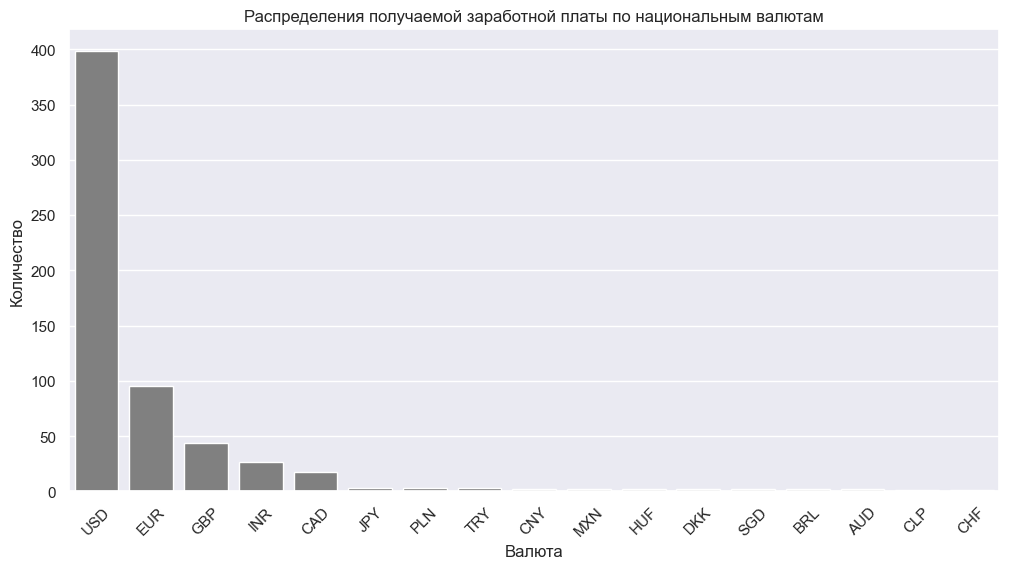

In [201]:
#Для наглядности изобразим графически
fig = plt.figure(figsize=(12,6))
barplot = sns.barplot(x = 'salary_currency', y = 'count', data = data['salary_currency'].value_counts().reset_index(),color = 'grey')
barplot.set_xticklabels(plot.get_xticklabels(), rotation=45)
barplot.set_title('Распределения получаемой заработной платы по национальным валютам')
plt.xlabel('Валюта')
plt.ylabel('Количество')

Основной валютой в датасете является доллар, поэтому в дальнейшем считаю целесообразным работать со столбцом salary_in_usd и поэтому мной принято решение удалить столбец "salary":

In [202]:
data.drop('salary',axis=1,inplace=True)

### Распределение заработной платы в долларах

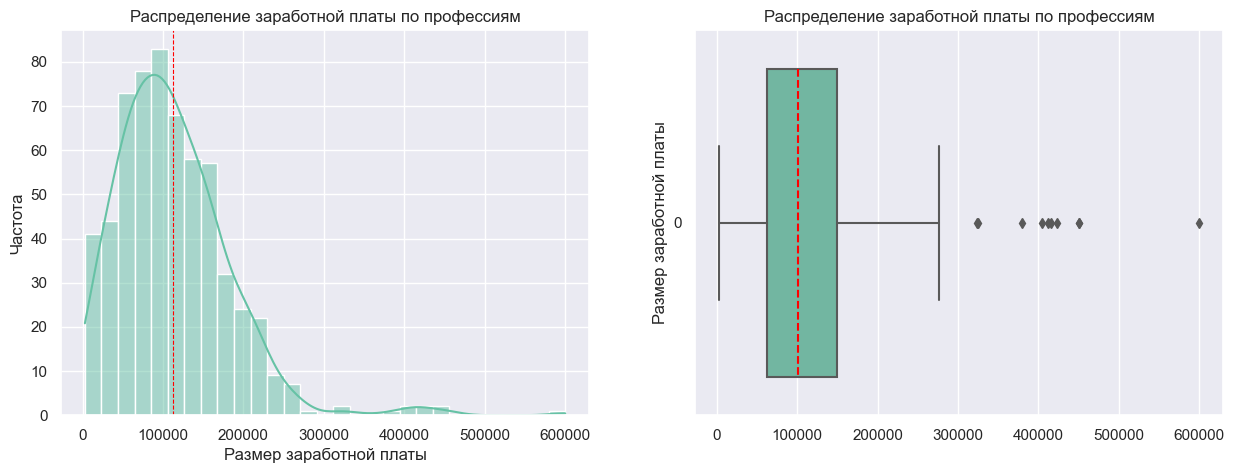

In [203]:
#Построим гистограмму и ящик с усами для того чтобы увидеть распределение зарплаты
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы', ylabel='Частота')
axes[0].set_title('Распределение заработной платы по профессиям')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы по профессиям')

plt.show()

In [204]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер заработной платы в долларах']
data_agg

,Размер заработной платы в долларах
count,607.00
mean,"112,297.87"
std,"70,957.26"
min,"2,859.00"
25%,"62,726.00"
50%,"101,570.00"
75%,"150,000.00"
max,"600,000.00"


*Распределение заработной платы отлично от нормального, имеются выбросы*

Поскольку выбросы могут негативно влиять на статистические тесты, принимаю решение удалить выбросы, пользуясь правилом трех сигм:

In [205]:
#Напишем функцию принимающая на вход столбец зарплат датасета
def outliers_indices(feature):
    '''
    Будем считать выбросами все точки, выходящие за пределы трёх сигм.
    '''
    mid = data[feature].mean()
    sigma = data[feature].std()
    return data[(data[feature] < mid - 3*sigma) | (data[feature] > mid + 3*sigma)].index

In [206]:
#применим функцию к нашему столбцу
salary = outliers_indices('salary_in_usd')
out = set(salary)

#Получаем 8 выбросов
print(len(out))

8


In [207]:
#Удалим выбросы с датасета
data.drop(out, inplace=True)

Проведем анализ корреляции числовых признаков, но сначала преобразуем порядковые признаки:

In [356]:
#Копируем датасет, чтобы не нарушать порядок
corr_df = data.copy() 

#проиводим преобразование категориальной шкалы в количественную.
corr_df['experience_level']= corr_df['experience_level'].replace({'EN':1, 'MI':2, 'SE':3,'EX':4})
corr_df['remote_ratio'] = corr_df['remote_ratio'].replace({0:1,50:2,100:3})
corr_df['company_size'] = corr_df['company_size'].replace({'S':1,'M':2,'L':3})


In [357]:
#произведем корреляцию Spearmen для непрерывных переменных
corr_df[['experience_level','remote_ratio','company_size','salary_in_usd','work_year']].corr(method='spearman')

,experience_level,remote_ratio,company_size,salary_in_usd,work_year
experience_level,1.00,0.12,0.02,0.56,0.32
remote_ratio,0.12,1.00,-0.06,0.18,0.12
company_size,0.02,-0.06,1.00,0.11,-0.15
salary_in_usd,0.56,0.18,0.11,1.00,0.30
work_year,0.32,0.12,-0.15,0.30,1.00


[Text(0.5, 1.0, 'Тепловая карта значений корреляций')]

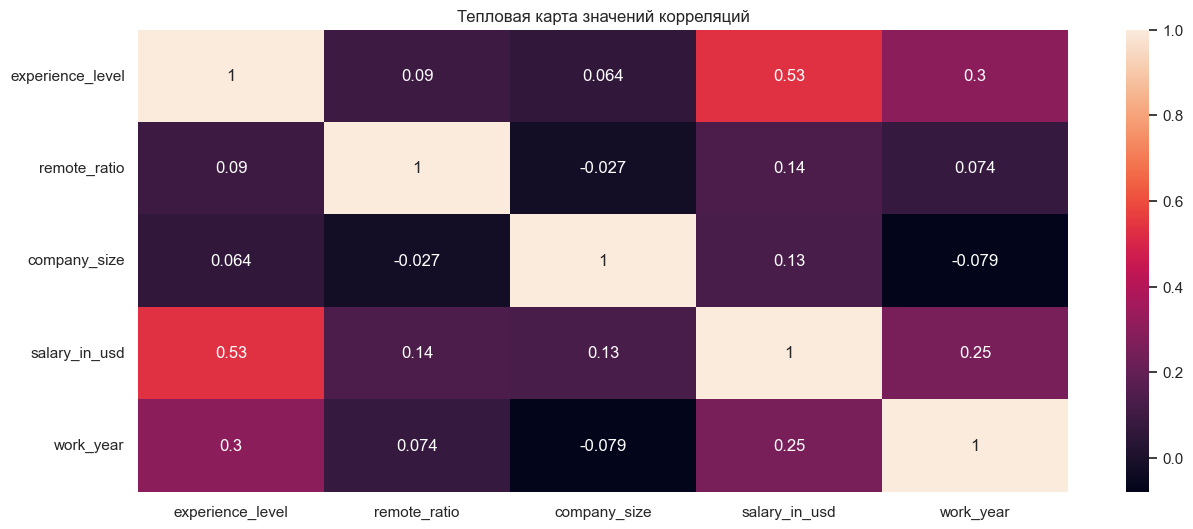

In [358]:
fig=plt.figure(figsize=(15,6))
heatmap = sns.heatmap(corr_df[['experience_level','remote_ratio','company_size','salary_in_usd','work_year']].corr(),annot=True)
heatmap.set(title = 'Тепловая карта значений корреляций')

*Среди представленных данных зарплата больше всего коррелирует с опытом работы, далее по убыванию с годом, в котором была выплачена зарплата.*

### ОПИСАНИЕ ПРИЗНАКОВ

#### ОБЩИЙ АНАЛИЗ ПРИЗНАКОВ В РАЗРЕЗЕ КОЛИЧЕСТВА И ЗАРАБОТНОЙ ПЛАТЫ

Для категориальных признаков будем строить графики по количеству и в разрезе зарплат. Узнаем какие факторы влияют на размер заработной платы.

В столбце job_title 50 уникальных значений, с целью не загромождать график, отобрал 5 профессий, наиболее часто встречающихся в датасете:

[Text(0.5, 0, 'Роль соискателя'), Text(0, 0.5, 'Зарплата')]

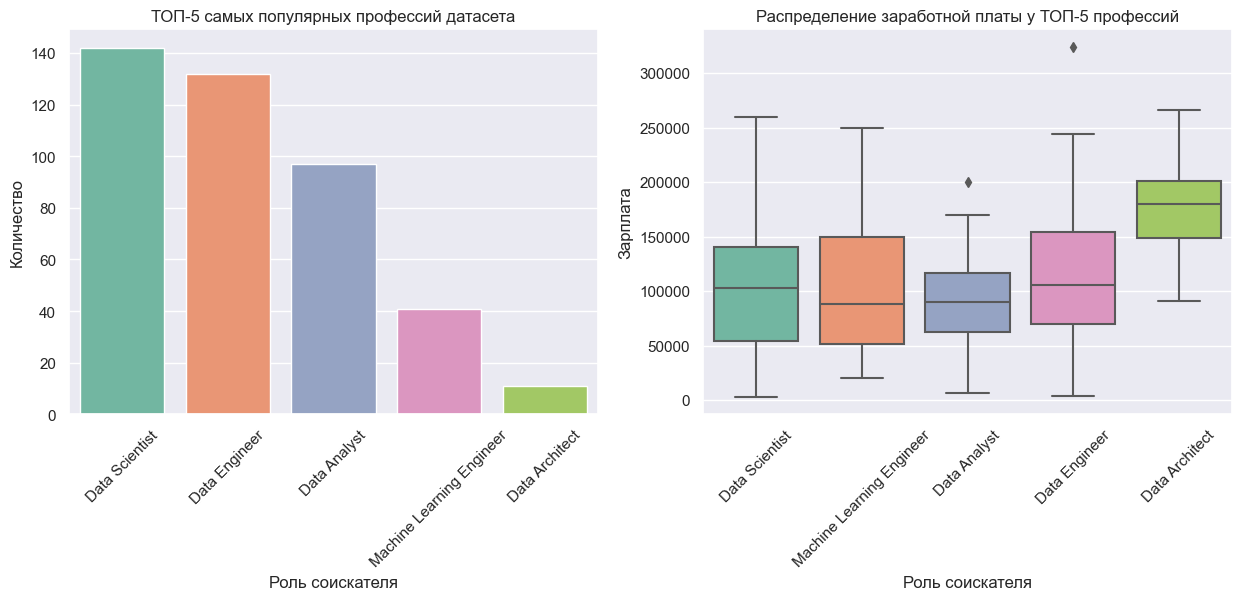

In [208]:
#В первую очередь создадим датафрейм с пятью топовыми профессиями 
df = data.groupby('job_title').agg({'job_title':['count'],'salary_in_usd':['sum']}).reset_index()
df.columns=['Название','Количество','Зарплата']
df = df.sort_values(by='Зарплата',ascending=False)[:5]

#На основе полученного датафрейма создадим два графика: столбчатую диаграмму и ящик с усами
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.barplot(x=df['Название'],y=df['Количество'],ax=axes[0])
axes[0].set_xticklabels(df['Название'].unique(), rotation=45)
axes[0].set_title('ТОП-5 самых популярных профессий датасета')
axes[0].set(xlabel='Роль соискателя', ylabel='Количество')

job_list = ['Data Scientist','Data Engineer','Data Analyst','Machine Learning Engineer','Data Architect']
filter = data[data['job_title'].isin(job_list)]
sns.boxplot(filter, x = 'job_title',y = 'salary_in_usd',ax=axes[1])
axes[1].set_xticklabels(filter['job_title'].unique(), rotation=45)
axes[1].set_title('Распределение заработной платы у ТОП-5 профессий')
axes[1].set(xlabel='Роль соискателя', ylabel='Зарплата')



In [210]:
#методом groupby() более детально изучим зарплаты
filter.groupby('job_title')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Analyst,97.00,"92,893.06","39,961.08","6,072.00","62,000.00","90,320.00","116,150.00","200,000.00"
Data Architect,11.00,"177,873.91","45,714.72","90,700.00","148,900.00","180,000.00","200,669.50","266,400.00"
Data Engineer,132.00,"112,725.00","57,629.08","4,000.00","70,039.50","105,500.00","154,600.00","324,000.00"
Data Scientist,142.00,"106,048.31","58,994.71","2,859.00","53,958.00","102,895.50","140,400.00","260,000.00"
Machine Learning Engineer,41.00,"104,880.15","63,218.63","20,000.00","51,064.00","87,932.00","150,000.00","250,000.00"


*У 5 самых упоминаемых профессий датасета ситуация с зарплатой обстоит следующим образом: по количеству вакансий лидируют Data Scientist и Data Engineer, по зарплате более выскооплачиваемая профессия - Data Architect. Выбросы имеются у Data Scientist, Data Analyst, Data Engineer. Распределение зарплаты, кроме максимальных значений, у Data Scientist, Data Engineer, Machine Learning Engineer примерно одинаковая.*

Далее построим графики иллюстрирующие количество вакансий по опыту работу(experience_level), а также влияния данного признака на зарплату:

Text(0.5, 1.0, 'Количество вакансий (%) по опыту')

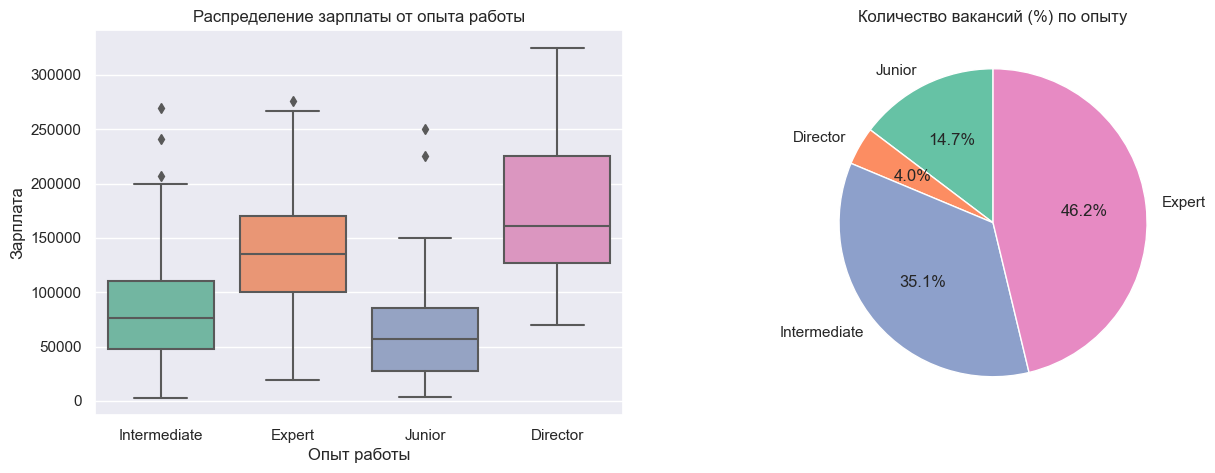

In [211]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

#Построим график ящик с усами распределения зарплат по опыту
sns.boxplot(x=data['experience_level'].replace({'EN':'Junior','MI':'Intermediate','SE':'Expert','EX':'Director'}),y=data['salary_in_usd'],ax=axes[0])
axes[0].set(xlabel='Опыт работы',ylabel='Зарплата')
axes[0].set_title('Распределение зарплаты от опыта работы')

#Построим круговую диаграмму с процентным соотношением по количеству вакансий с опытом работы
new = data.groupby('experience_level')['job_title'].count().reset_index()
new.columns = ['Опыт работы','Количество']
new['Опыт работы'] = new['Опыт работы'].replace({'EN':'Junior','MI':'Intermediate','SE':'Expert','EX':'Director'})
plt.pie(labels=new['Опыт работы'],x=new['Количество'],autopct='%1.1f%%',
    startangle=90)
plt.title('Количество вакансий (%) по опыту')






In [212]:
#Более детально изучим заработнуб плату по опыту работы
data.groupby(['experience_level'])['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.00,"61,643.32","44,395.54","4,000.00","27,505.00","56,500.00","85,425.75","250,000.00"
EX,24.00,"173,674.71","72,039.57","69,741.00","127,046.75","160,771.00","225,500.00","325,000.00"
MI,210.00,"82,953.14","48,222.34","2,859.00","47,461.50","76,357.00","110,000.00","270,000.00"
SE,277.00,"135,797.26","51,162.12","18,907.00","100,000.00","135,000.00","170,000.00","276,000.00"


*По опыту работы можно сказать следующее: самый высокооплачиваемый по опыту работы по датасету -  Director (EX), несмотря на то, что вакансии с данным опытом работы представлен меньше всего в датасете. Далее идет Expert (SE) - вакансии с данным опытом работы, занимают большую часть датасета. Далее в порядке убывания - Intermediate(MI) - средний уровень, Junior (EN). Во всех группах наблюдаются выбросы, данные распределены не нормально*

Далее построим графики, показывающие количество и распределение по зарплате вакансий по типу трудоустройства:

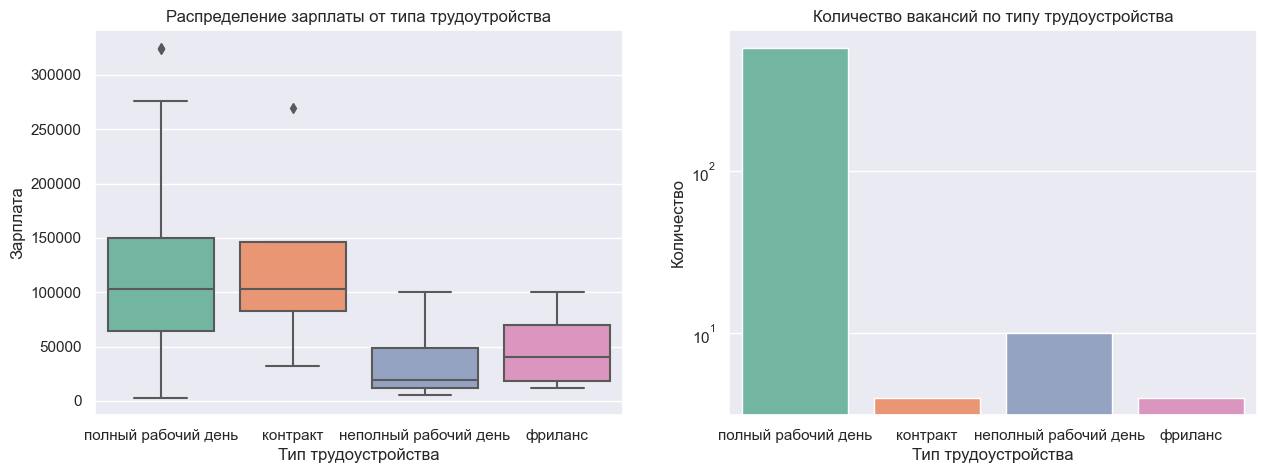

In [213]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Ящик с усами распределения зарплат по типу трудоуствройства
sns.boxplot(x=data['employment_type'].replace({'FT':'полный рабочий день', 'CT':'контракт','PT':'неполный рабочий день','FL':'фриланс'}),y=data['salary_in_usd'],ax=axes[0])
axes[0].set(xlabel='Тип трудоустройства',ylabel='Зарплата')
axes[0].set_title('Распределение зарплаты от типа трудоутройства')

#Столбчатая диаграмма с количеством вакансий по типу трудоустройства
sns.countplot(x = data['employment_type'].replace({'FT':'полный рабочий день', 'CT':'контракт','PT':'неполный рабочий день','FL':'фриланс'}))
plt.title('Количество вакансий по типу трудоустройства')
plt.xlabel('Тип трудоустройства')
plt.ylabel('Количество')
plt.yscale('log')

In [214]:
#Детальное рассмотрения зарплат по типу трудоустройства
data.groupby('employment_type')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,4.00,"126,718.75","101,177.15","31,875.00","82,968.75","102,500.00","146,250.00","270,000.00"
FL,4.00,"48,000.00","40,529.82","12,000.00","18,000.00","40,000.00","70,000.00","100,000.00"
FT,581.00,"109,465.11","59,014.10","2,859.00","63,900.00","102,839.00","150,000.00","325,000.00"
PT,10.00,"33,070.50","31,472.91","5,409.00","12,000.00","18,817.50","48,370.00","100,000.00"


*По типу трудоустройства: подавляющее большинство работали на полный рабочий день (FT), остальные типы трудоустройств значительно уступают. У типа трудоустройства контракт(CT), неполного рабочего дня (PT) распределения сильно смещены вправо. Данные не распределены нормально. Распределение полного рабочего дня имеет выбросы. Из за малого количества наблюдений у некоторых групп, тяжело проследить влияние на зарплату*

Далее подходим к исследованию влияния нахождения главного офиса работодателя на зарплату, а также местонахождения работников. Из за того, что данные этих двух столбцов, представляют собой кодировку стран ISO 3166, построение графиков, а также чтение данных может показаться затруднительным. Из-за того, что эти столбцы содержат множество уникальных значений, заменить вручную кодировку на названия стран, кажется процессом слишком долгим, поэтому можно с помощью библиотеки beatifulSoup упростить данный процесс:

In [215]:
from bs4 import BeautifulSoup
import requests

#Источник данных мной выбрана википедия
url = 'https://ru.wikipedia.org/wiki/ISO_3166-1'
page = requests.get(url)
soup = BeautifulSoup(page.text, "html.parser")
a = soup.findAll('b')
iso = [link.text for link in a if len(link.text) ==2]

#Избавляемся от лишних элементов перед формированием датасета
import re
country = [link.text for link in a if re.search('[а-яА-Я]', link.text)]
country = country[3:]
for i in range(len(country)):
    country[i] = country[i].replace('\xa0','')

#формируем новый датасет с расшифровкой кодов ISO 3166
df = pd.DataFrame({'iso':iso,'country':country})
   


In [216]:
#Присоеденяем получившийся датасет к нашему.
data = data.merge(df,left_on='employee_residence',right_on='iso').merge(df,left_on='company_location',right_on='iso')

In [217]:
#Удаляем лишние столбцы получившиеся столбцы, а также столбцы с кодировками iso 3166
data.drop(columns=['employee_residence','company_location','iso_x','iso_y'],axis=1,inplace=True)

#переиминовываем столбцы с понятными названиями на русском языке
data.rename({'country_x':'employee_residence','country_y':'company_location'},axis=1,inplace=True)

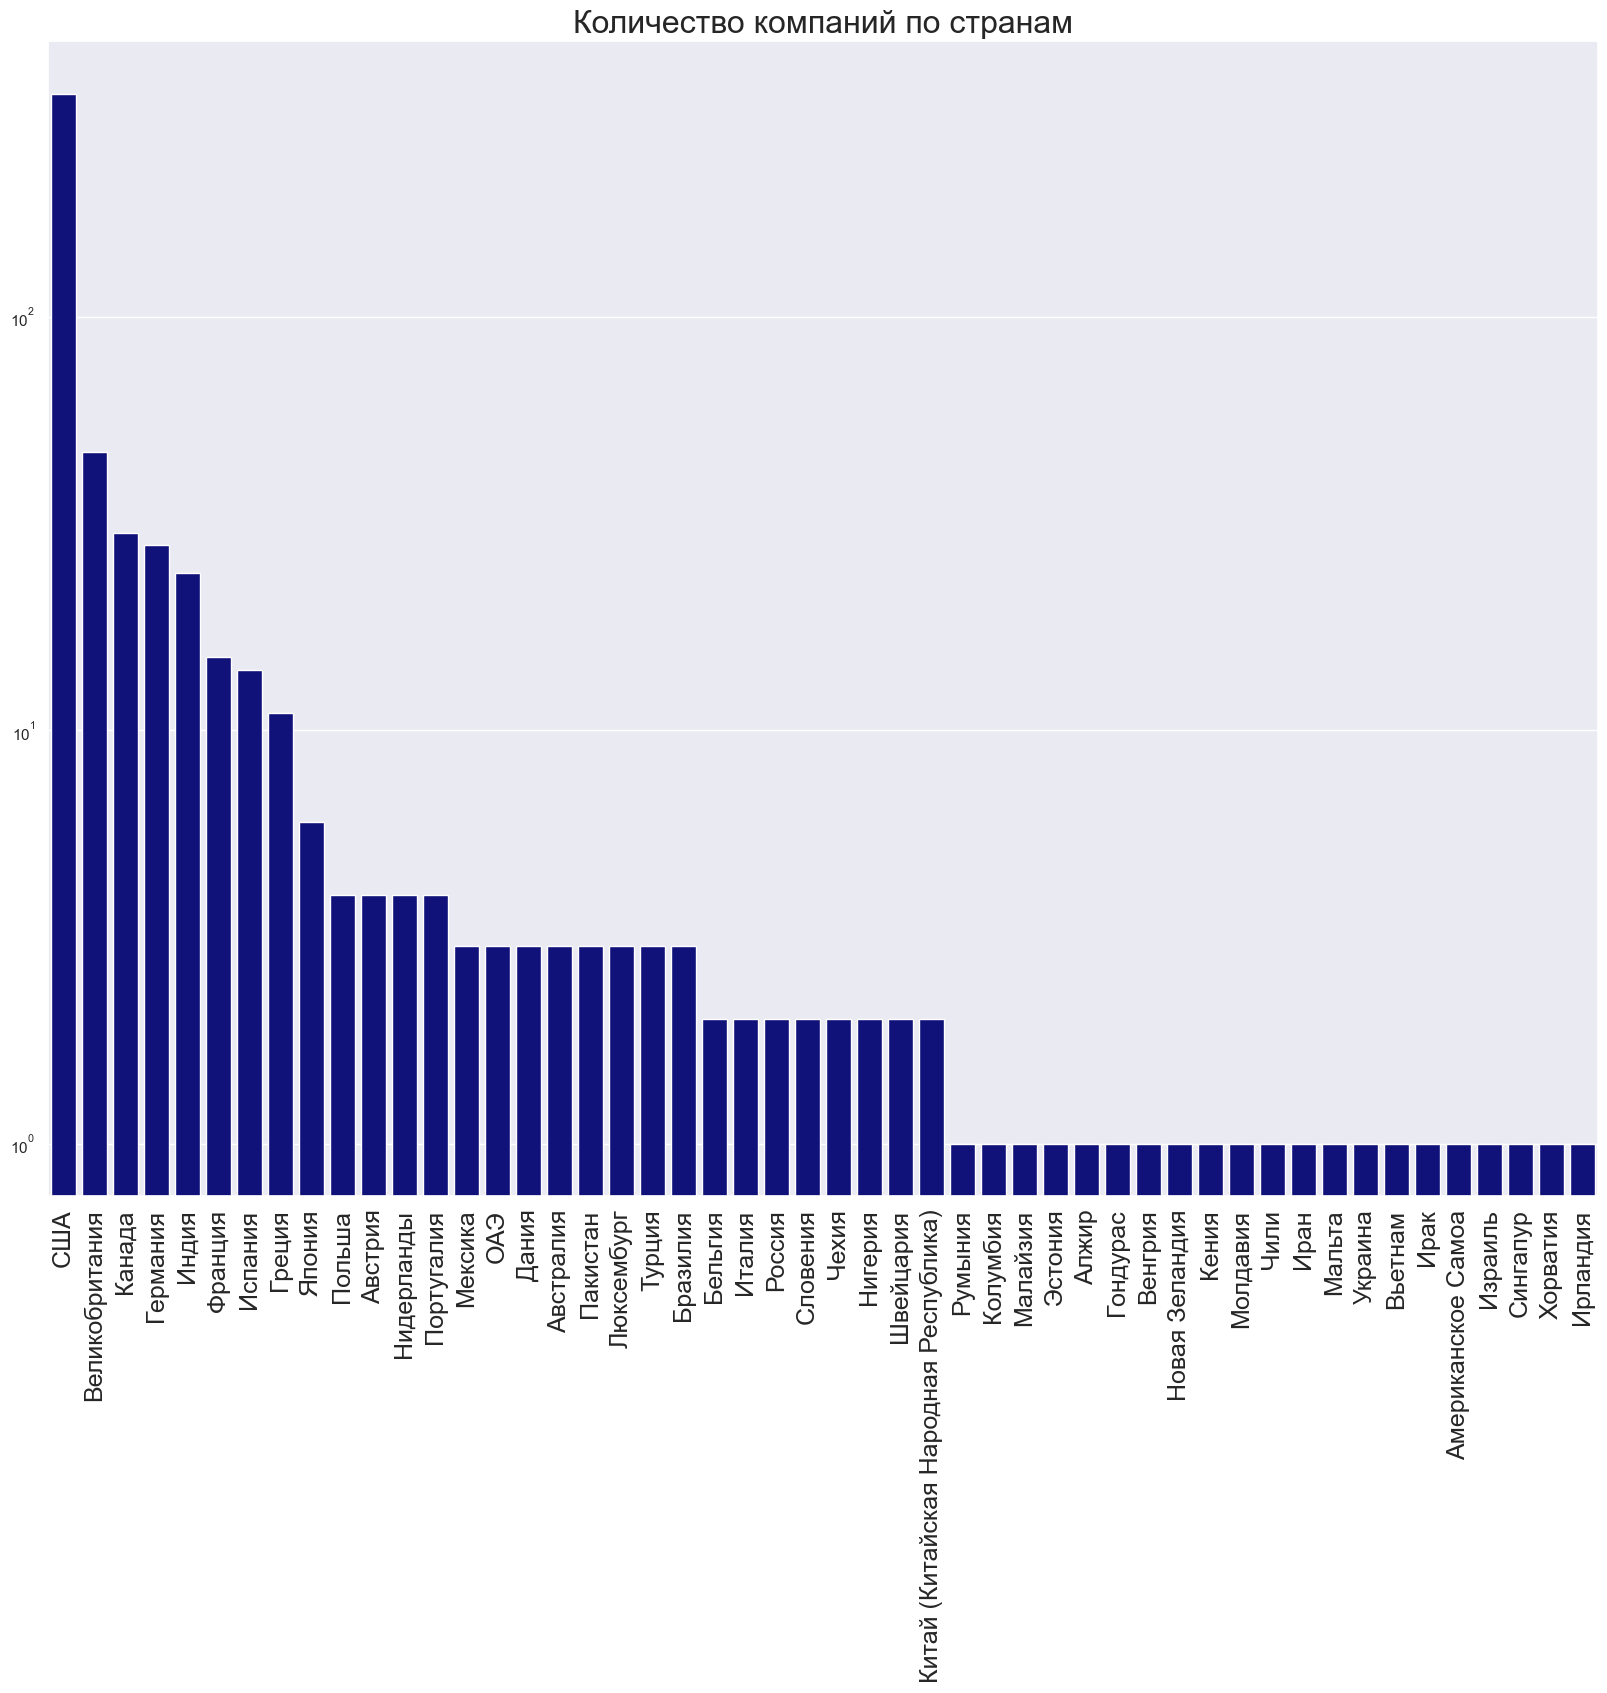

In [218]:
#сформируем датасет для построения графика по количеству стран, где располагаются компании
location = data['company_location'].value_counts().to_frame().reset_index()
location.columns = ['company_location','count']

#построим столбчатую диаграмму по количеству стран
sns.set(rc={'figure.figsize':(20,15)})
plot = sns.barplot(x=location['company_location'],y=location['count'],color='darkblue')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, fontdict={'fontsize':18})
plot.set_title('Количество компаний по странам',fontdict={'fontsize':23})
plot.set(xlabel='',ylabel='')
plt.yscale('log')

Text(0, 0.5, 'Значения зарплат')

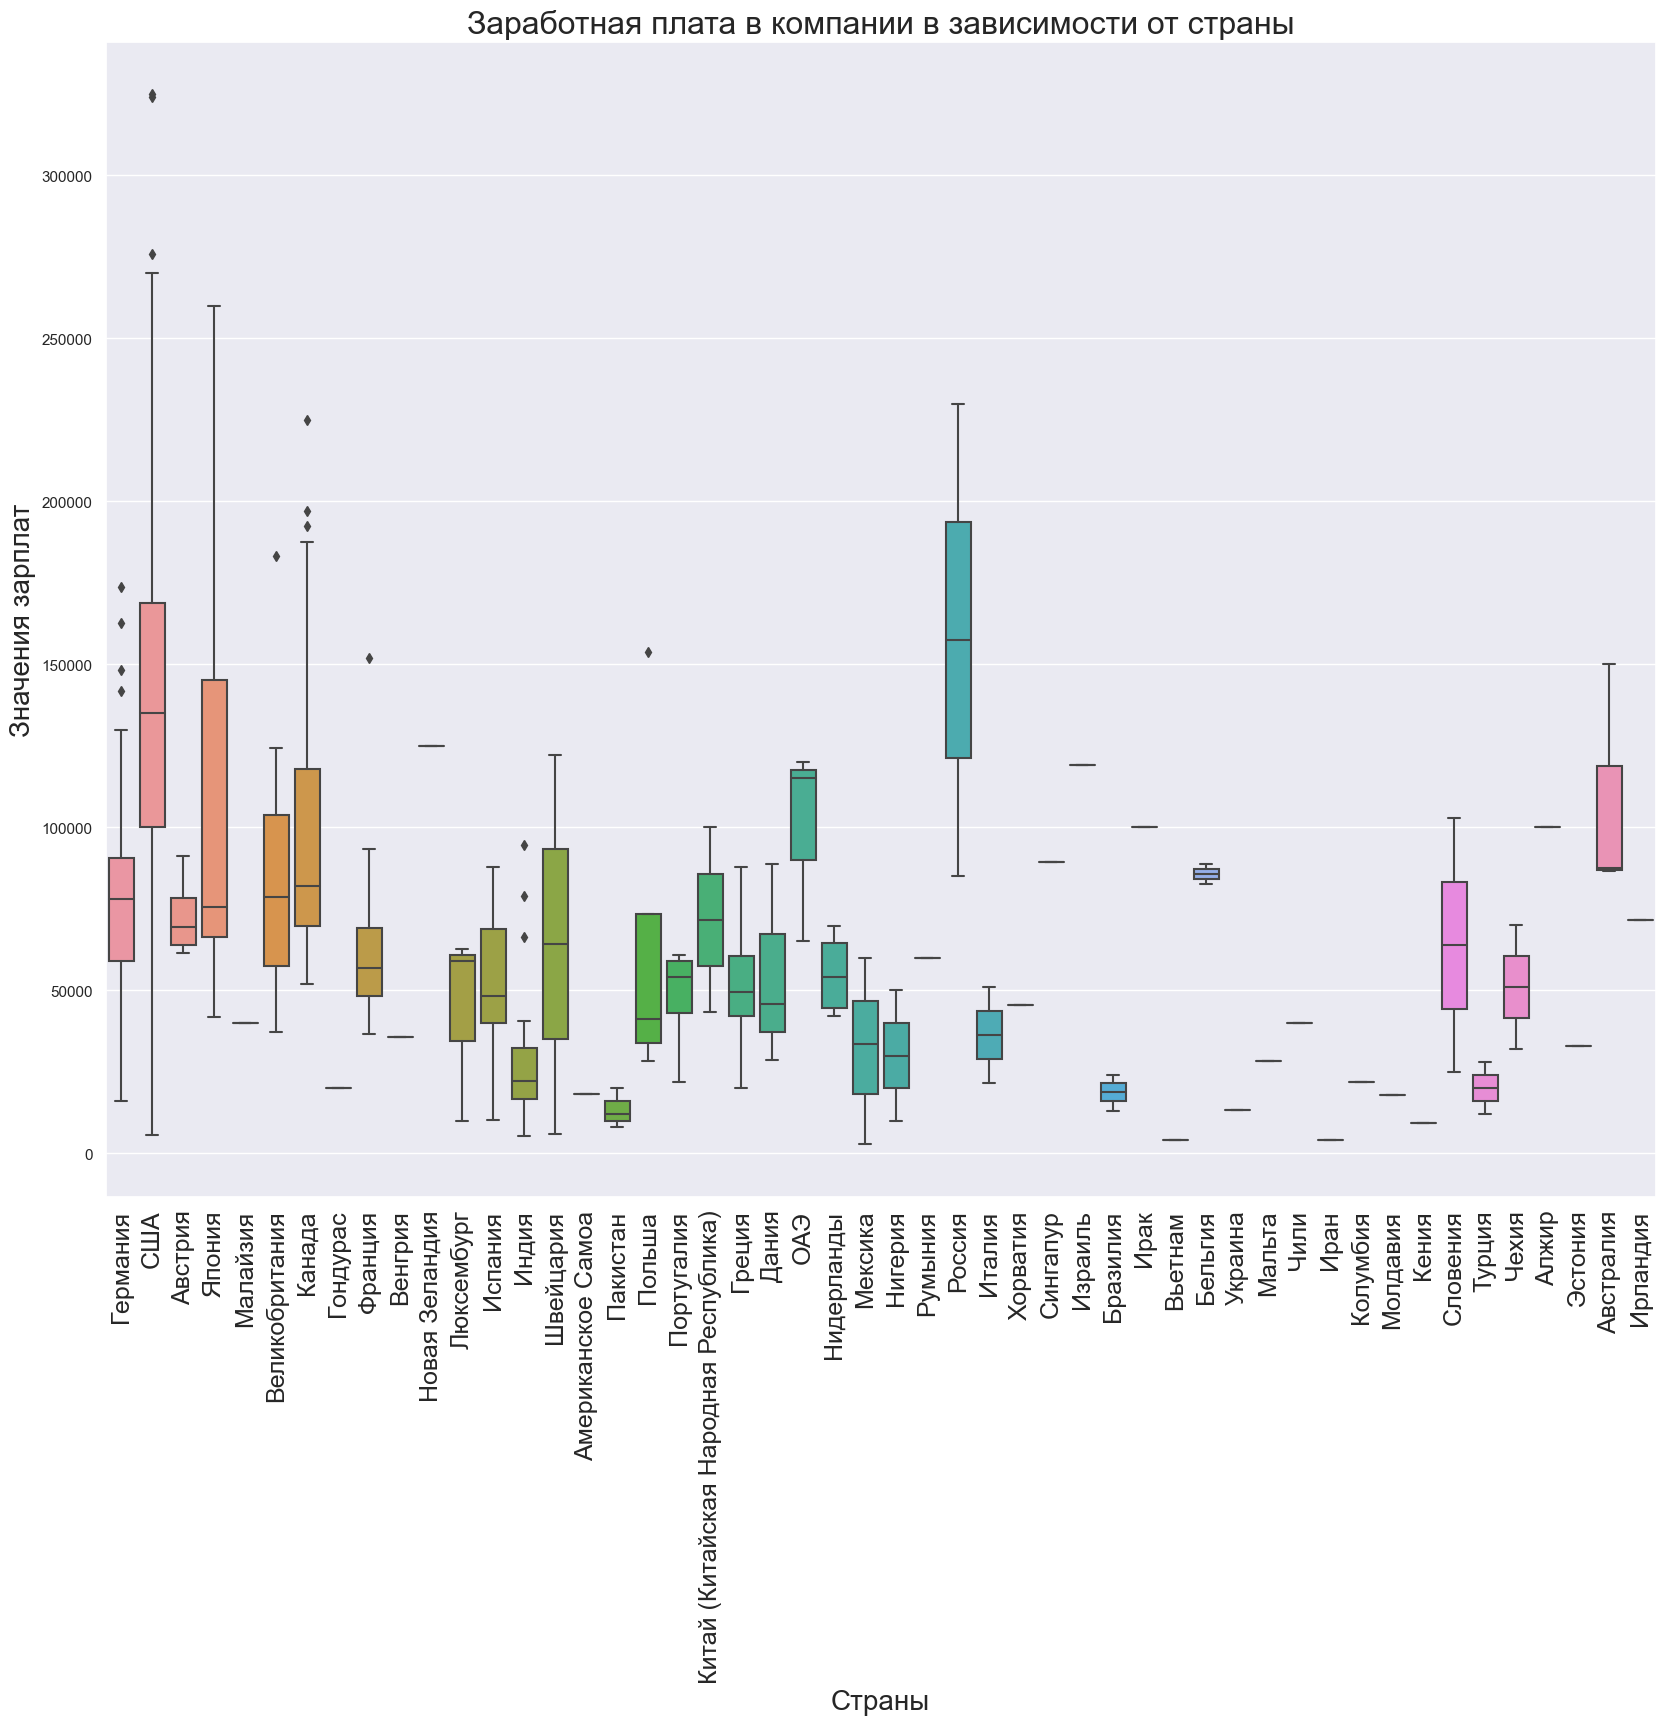

In [219]:
#сформируем ящик с усами по распределению зарплат по расположению компании в странах
sns.set(rc={'figure.figsize':(20,15)})
plot = sns.boxplot(x=data['company_location'],y=data['salary_in_usd'])
plot.set_title('Заработная плата в компании в зависимости от страны',fontdict={'fontsize':23})
plot.set_xticklabels(data['company_location'].unique(), rotation=90,fontdict={'fontsize':18})
plot.set_xlabel("Страны", fontsize=20)
plot.set_ylabel("Значения зарплат", fontsize=20)

In [220]:
#Детально рассмотрим распределение с упором на количество, отберем только 10 стран с самым высоким количеством офисов
data.groupby('company_location')['salary_in_usd'].describe().sort_values(by=['count','mean','50%','75%'],ascending=False)[:10]

,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
США,347.00,"137,186.22","52,980.68","5,679.00","100,000.00","135,000.00","168,937.50","325,000.00"
Великобритания,47.00,"81,583.04","29,524.01","37,300.00","57,575.00","78,526.00","103,931.00","183,228.00"
Канада,30.00,"99,823.73","46,329.10","52,000.00","69,730.00","81,895.50","117,916.25","225,000.00"
Германия,28.00,"81,887.21","39,195.88","15,966.00","58,986.00","78,015.00","90,734.00","173,762.00"
Индия,24.00,"28,581.75","22,697.67","5,409.00","16,735.00","22,124.00","32,163.25","94,665.00"
Франция,15.00,"63,970.67","28,679.63","36,643.00","48,202.50","56,738.00","69,143.00","152,000.00"
Испания,14.00,"53,060.14","21,090.92","10,354.00","40,073.50","48,371.50","68,793.00","87,932.00"
Греция,11.00,"52,293.09","19,332.69","20,000.00","42,077.50","49,461.00","60,453.00","87,932.00"
Япония,6.00,"114,127.33","83,584.64","41,689.00","66,283.25","75,682.00","145,341.00","260,000.00"


*Можно сделать вывод, что самое большое количество офисов располагаются в США, Великобритании, Канаде, Германии, Индии, Франции, Греции. По заработной плате из указанных стран лидирует США, Канада, Великобритания, Германия, Франция. Индия, имеющая высокую долю офисов работодателя, высокими зарплатами среди данных стран не отличается.* 

Далее для сведения построим столбчатую диаграмму, показывающее количество стран, где проживали сотрудники в течение рабочего года:

Text(0.5, 1.0, 'Количество сотрудников проживавших в странах течение рабочего года')

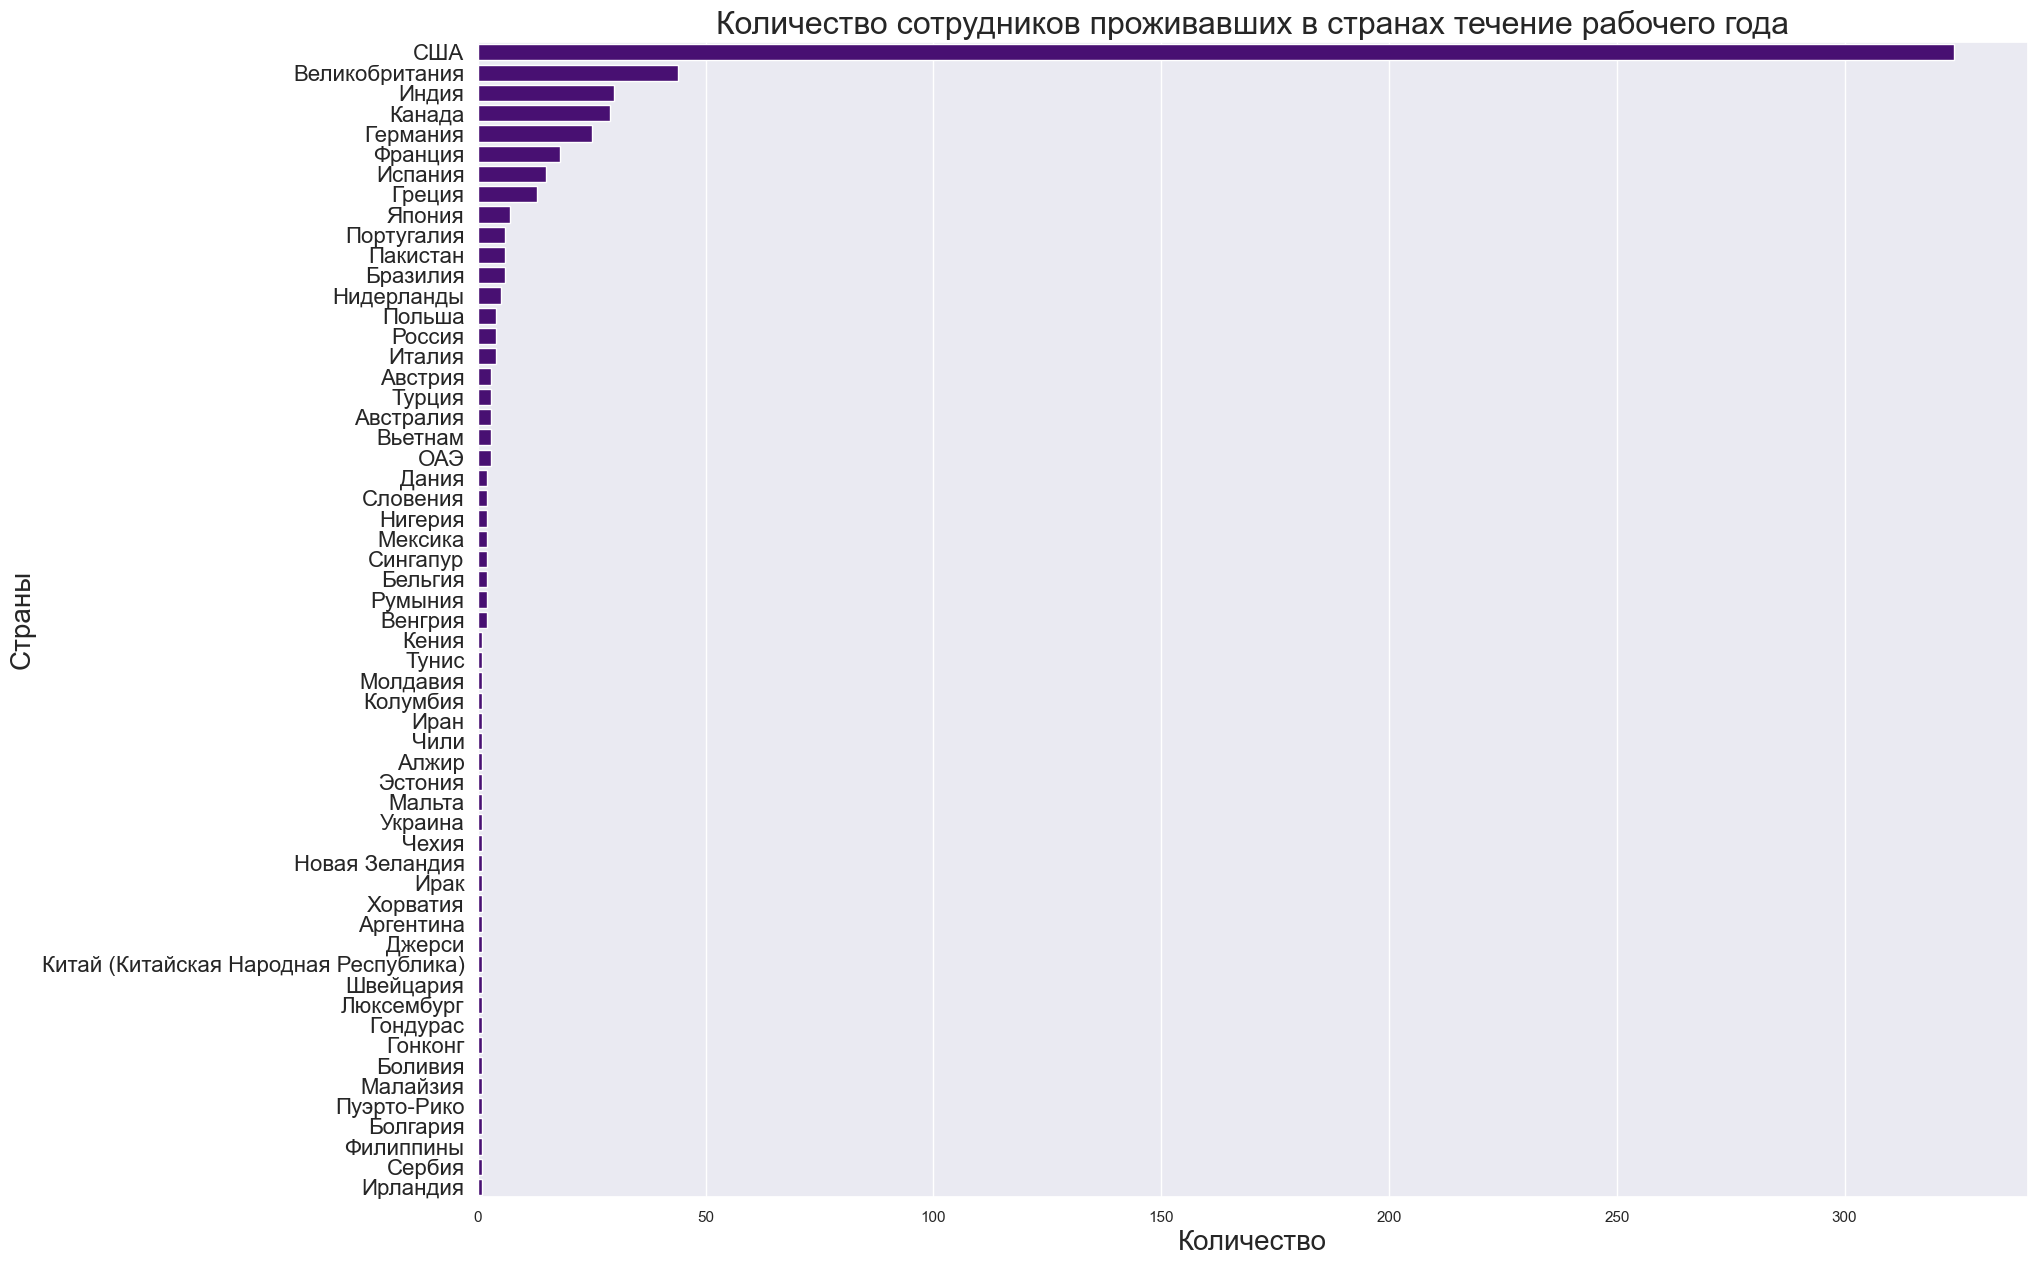

In [221]:
employee_residence = data['employee_residence'].value_counts().to_frame().reset_index()
plot = sns.barplot(y=employee_residence['employee_residence'],x=employee_residence['count'],color='indigo')
plot.set_yticklabels(employee_residence['employee_residence'].unique(),fontdict={'fontsize':16})
plot.set_xlabel("Количество", fontsize=20)
plot.set_ylabel("Страны", fontsize=20)
plot.set_title('Количество сотрудников проживавших в странах течение рабочего года',fontdict={'fontsize':23})

*Подавляющее большинство работников проживало все в тех же странах, где и располагаются офисы компаний: США, Великобритания, Индия, Канада, Германия, Франция. Исследовать влияние этого признака на заработную плату не стану*

Далее исследуем, влияет объем работы выполненной удаленно на заработную плату:

[Text(0.5, 0, ''), Text(0, 0.5, 'Заработная плата')]

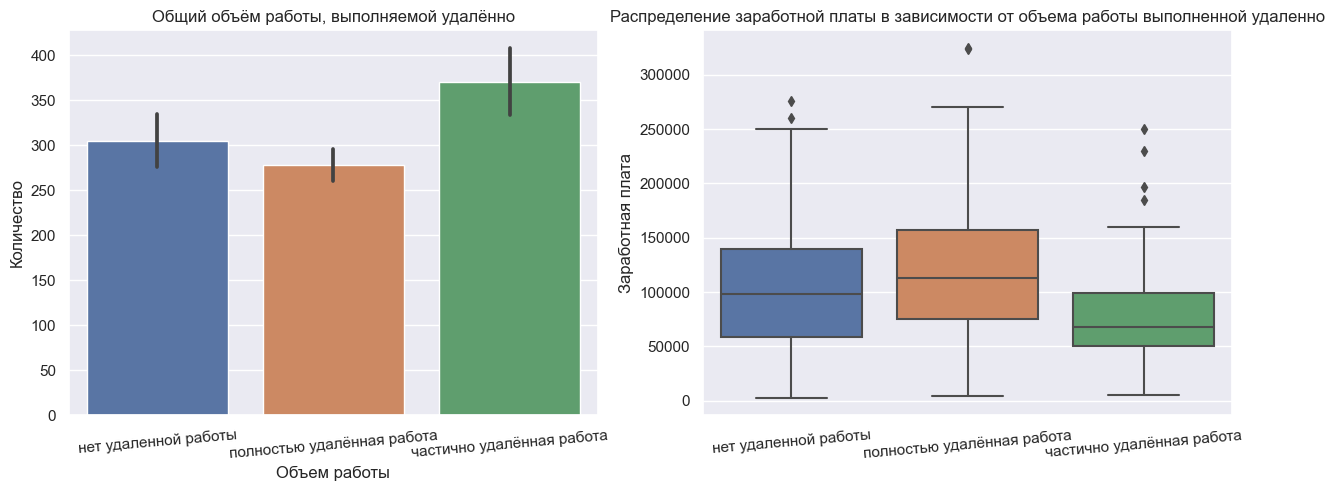

In [222]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

#Построим столбчатую диаграмму количества значений датасета объема работы, сделаем график более понимаемым
sns.barplot(x=data['remote_ratio'].replace({0:'нет удаленной работы',50:'частично удалённая работа',100:'полностью удалённая работа'}),y=data.index,ax=axes[0])
axes[0].set_title('Общий объём работы, выполняемой удалённо')
axes[0].set(xlabel='Объем работы', ylabel='Количество')
axes[0].set_xticklabels(data['remote_ratio'].replace({0:'нет удаленной работы',50:'частично удалённая работа',100:'полностью удалённая работа'}).unique(),rotation = 5)

#Ящик с усами распределения заработной платы по объему работ, выполняемой удаленно
sns.boxplot(x=data['remote_ratio'].replace({0:'нет удаленной работы',50:'частично удалённая работа',100:'полностью удалённая работа'}),y=data['salary_in_usd'],ax=axes[1])
axes[1].set_title('Распределение заработной платы в зависимости от объема работы выполненной удаленно')
axes[1].set_xticklabels(data['remote_ratio'].replace({0:'нет удаленной работы',50:'частично удалённая работа',100:'полностью удалённая работа'}).unique(),rotation = 5)
axes[1].set(xlabel='', ylabel='Заработная плата')

In [223]:
#Детально посмотрим информацию
data.groupby('remote_ratio')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,126.00,"103,627.28","60,589.37","2,859.00","59,000.00","98,579.00","139,300.00","276,000.00"
50,98.00,"77,331.43","45,868.39","5,409.00","50,000.50","68,010.50","98,847.75","250,000.00"
100,375.00,"117,315.44","60,026.79","4,000.00","75,000.00","112,900.00","156,800.00","325,000.00"


*Большинство работников выполняли работу частично удаленно, далее в офисе, немного уступает по количеству полностью удаленная работа. По уровням зарплат, объем работ выполняемой удаленно оплачивается больше. Меньше всего среди трех групп оплачивается частично удаленная работа. Все три группы имеют выбросы и ненормально распределены*

И наконец проследим влияние размера компании на размер зарплаты:

Text(0.5, 1.0, 'Распределение заработной платы в зависимости от размера компании')

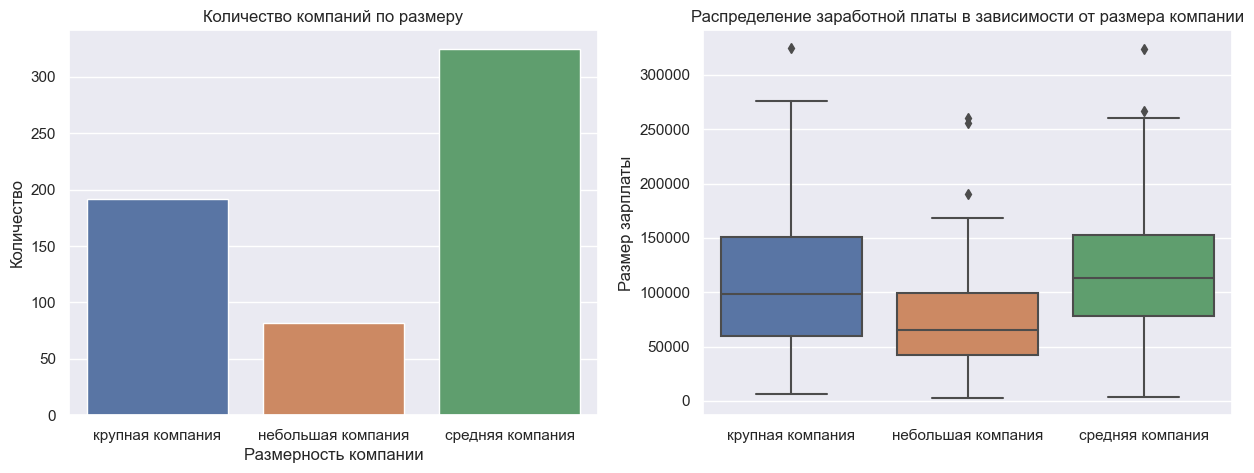

In [224]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

#Построим столбчатую диаграмму по количеству значений в датасете
sns.countplot(x=data['company_size'].replace({'S':'небольшая компания','M':'средняя компания','L':'крупная компания'}),ax=axes[0])
axes[0].set(xlabel='Размерность компании', ylabel='Количество')
axes[0].set_title('Количество компаний по размеру')

#диаграмма распределения зарплат в зависмости от размера компании
sns.boxplot(x=data['company_size'].replace({'S':'небольшая компания','M':'средняя компания','L':'крупная компания'}),y=data['salary_in_usd'],ax=axes[1])
axes[1].set(xlabel='',ylabel='Размер зарплаты')
axes[1].set_title('Распределение заработной платы в зависимости от размера компании')


In [225]:
data.groupby('company_size')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,192.00,"109,063.09","63,669.51","5,882.00","59,775.50","98,141.00","151,250.00","325,000.00"
M,325.00,"115,880.56","56,412.60","4,000.00","78,000.00","112,900.00","152,500.00","324,000.00"
S,82.00,"73,506.24","51,443.02","2,859.00","41,816.00","65,000.00","98,936.50","260,000.00"


*Большинство работников работало в средних по размеру компании. В средних компаниях оплачивают немного лучше чем в крупных компаниях: медианная зарплата в средних компаниях (М) - 113 188, в крупных (L) - 100 000, меньше всего в небольших компаниях (S) - 65 000. Во всех трех группах имеютя выбросы*

#### Анализ признаков участвующих в исследовании

Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Text(0, 0.5, 'Распределение')

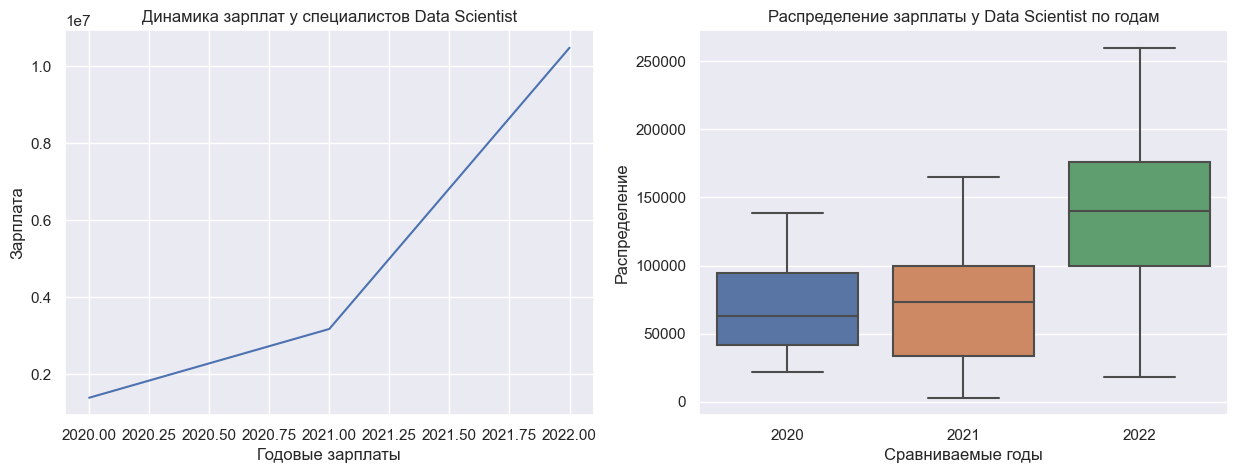

In [226]:
#Отфильтруем график по названию профессии - Data Scientist
ds_df = data[data['job_title']=='Data Scientist']
group_df = ds_df.groupby('work_year')['salary_in_usd'].sum()

fig, axes = plt.subplots(1,2, figsize=(15, 5))
#Построим линейный график изменения зарплаты по годам
sns.lineplot(data=group_df, ax = axes[0])
axes[0].set_title('Динамика зарплат у специалистов Data Scientist')
axes[0].set_xlabel('Годовые зарплаты')
axes[0].set_ylabel('Зарплата')


sns.boxplot(x = ds_df['work_year'],y = ds_df['salary_in_usd'],ax=axes[1])
axes[1].set_title('Распределение зарплаты у Data Scientist по годам')
axes[1].set_xlabel('Сравниваемые годы')
axes[1].set_ylabel('Распределение')


*По графику видно, что зарплата у специалиста Data Science с каждым годом увеличивается*

Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

[Text(0.5, 1.0, 'Распределение зарплат в 2022 году')]

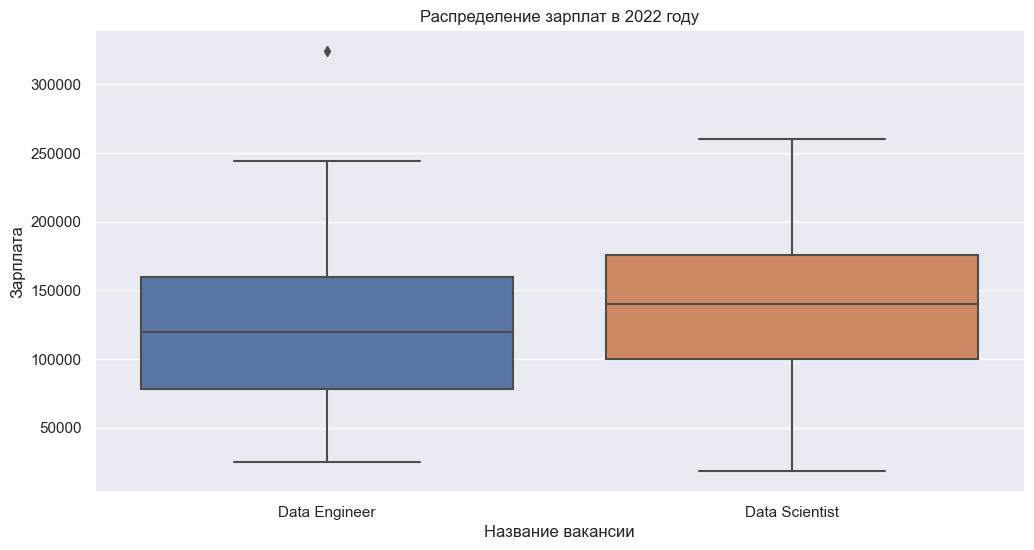

In [293]:
#отфильтруем датасет по двум вакансиям и по году для построения графика
data_df = data[((data.job_title =='Data Scientist') | (data.job_title =='Data Engineer')) & (data.work_year == 2022)]
data_df.rename({'job_title': 'Название вакансии'}, axis =1, inplace =True)

#построим ящик с усами
plt.figure(figsize=(12,6))
box = sns.boxplot(data_df, x = 'Название вакансии', y = 'salary_in_usd')
box.set(ylabel='Зарплата')
box.set(title = 'Распределение зарплат в 2022 году')


In [229]:
data_df.groupby('Название вакансии')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
Название вакансии,,,,,,,,
Data Engineer,89.00,"126,375.70","55,954.40","25,000.00","78,526.00","120,000.00","160,000.00","324,000.00"
Data Scientist,77.00,"136,172.09","54,563.08","18,442.00","100,000.00","140,000.00","176,000.00","260,000.00"


*Судя по графику и описательной статистики уровень зарплаты по всем параметрам у Data Scientist выше, чем у Data Engineer в 2022 году, распределение отлично от нормального, у позиции Data Engineer имеется выброс в зарплатах*

Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

[Text(0.5, 0, ''), Text(0, 0.5, 'Зарплата')]

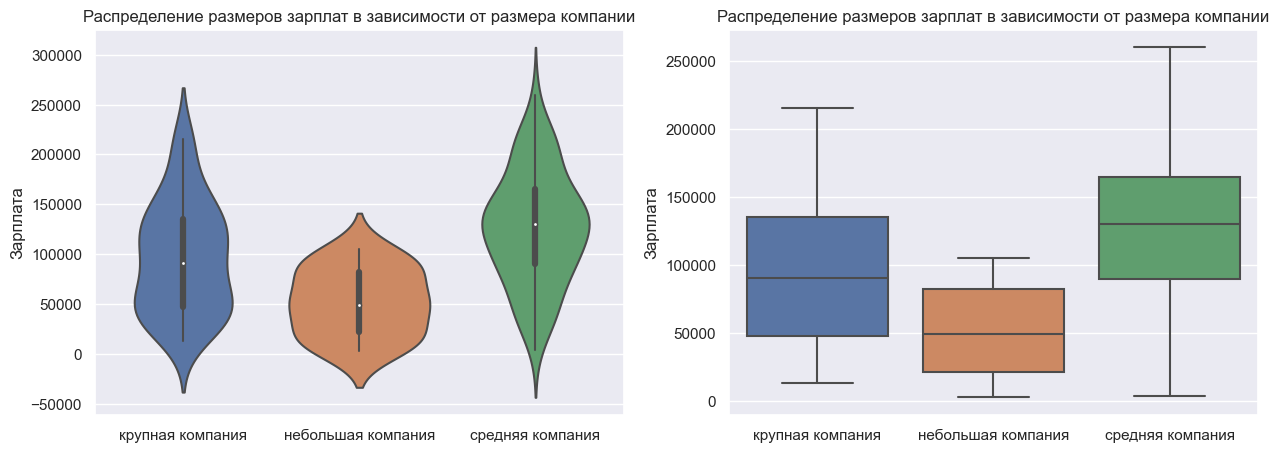

In [294]:
#Построим два графика, иллюстрирующих распределение зарплат, взависимости от размера компании
fig, axes = plt.subplots(1,2, figsize=(15, 5))

#violinplot
sns.violinplot(x = 'company_size', y = 'salary_in_usd', data = data[data['job_title']=='Data Scientist'],ax = axes[0])
axes[0].set_xticklabels(data[data['job_title']=='Data Scientist']['company_size'].replace({'S':'небольшая компания','M':'средняя компания','L':'крупная компания'}).unique())
axes[0].set(title = 'Распределение размеров зарплат в зависимости от размера компании')
axes[0].set(xlabel='',ylabel='Зарплата')

#boxplot
sns.boxplot(x = 'company_size', y = 'salary_in_usd', data = data[data['job_title']=='Data Scientist'],ax = axes[1])
axes[1].set_xticklabels(data[data['job_title']=='Data Scientist']['company_size'].replace({'S':'небольшая компания','M':'средняя компания','L':'крупная компания'}).unique())
axes[1].set(title = 'Распределение размеров зарплат в зависимости от размера компании')
axes[1].set(xlabel='',ylabel='Зарплата')

In [295]:
data[data['job_title']=='Data Scientist'].groupby('company_size')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,44.00,"96,297.75","54,872.66","13,400.00","47,620.25","90,734.00","135,000.00","215,300.00"
M,77.00,"126,380.75","56,389.53","4,000.00","90,000.00","130,000.00","165,000.00","260,000.00"
S,21.00,"51,925.76","33,216.29","2,859.00","21,669.00","49,268.00","82,500.00","105,000.00"


*Графики получились без выбросов, наиболее высокую зарплату Data Scientist получает в средних компаниях.*

Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

[Text(0.5, 1.0, 'Количество вакансии по размеру компании')]

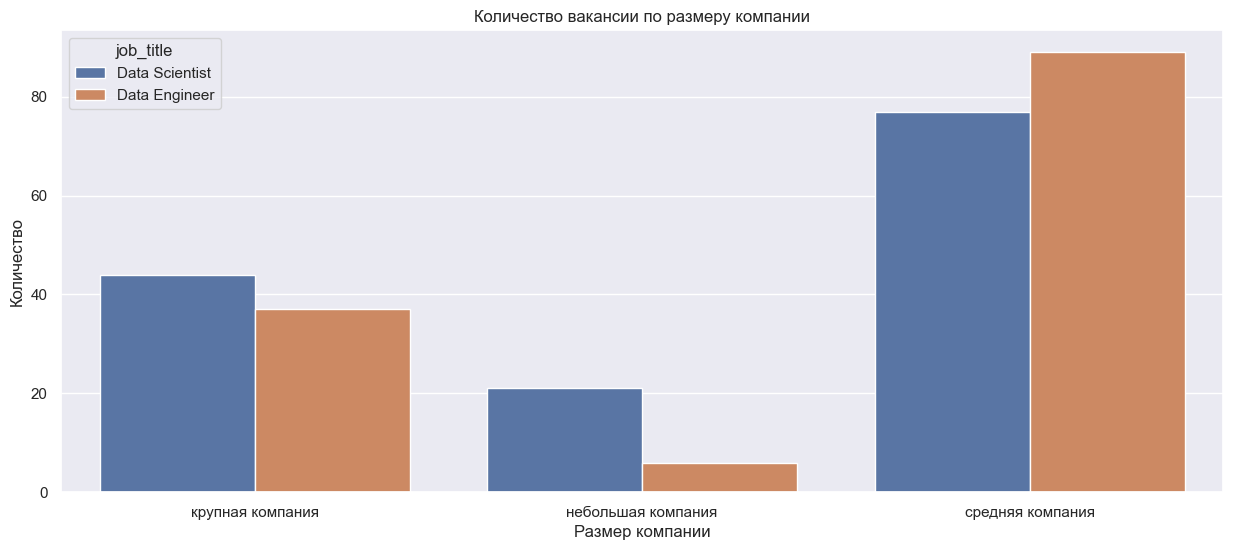

In [310]:
#отфильтруем датасет по двум профессиям
data_df = data[(data.job_title =='Data Scientist') | (data.job_title =='Data Engineer')]

#построим столбчатую диаграмму по двум группам в разрезе количества
fig = plt.figure(figsize = (15,6))
countplot = sns.countplot(x=data_df['company_size'].replace({'S':'небольшая компания','M':'средняя компания','L':'крупная компания'}), hue = data_df['job_title'])
countplot.set(xlabel='Размер компании', ylabel='Количество')
countplot.set(title='Количество вакансии по размеру компании')

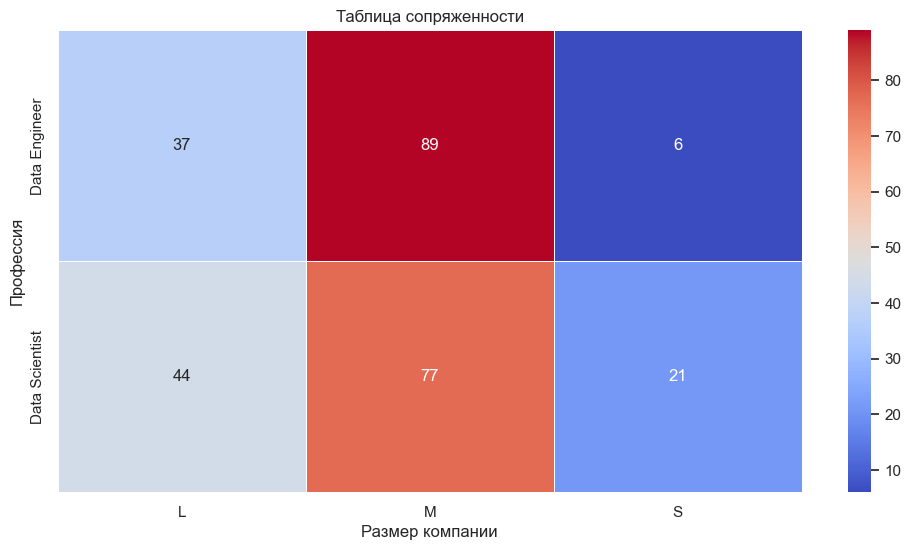

In [308]:
#Построим таблицу сопряженности для того, чтобы проследить взаимосвязь двух признаков
plt.figure(figsize=(12,6))
cross_tab = pd.crosstab(index=data_df['job_title'], columns=data_df['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Профессия')
plt.title('Таблица сопряженности')
plt.show()

*Какую-либо взаимосвязь проследить на данном этапе не представляется возможным. В средних компаниях, в отличии от небольших и больших, большинство вакансий представлены Data Scientist*

## Статистический анализ данных

In [311]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))
        
# функция определяющая равенство дисперсии
def decision_dispersion(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости 0.05. Дисперсии не одинаковы')
    else:
        print('p-значение больше, чем заданный уровень значимости 0.05. Дисперсии одинаковы')

# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Проверку будем проводить в два этапа, т.е. сравним зарплату специалистов Data Scientist по годам поочередно** 

**Сформулируем нулевую и альтернативные гипотезы по зарплатам Data Scientist за 2020 и за 2021 года**

*Нулевая гипотеза* ($H_0$): ежегодный рост зарплат за 2020  ($\mu_1$), 2021 ($\mu_2$) не наблюдается:
$$ H_0 : \mu_1 >= \mu_2$$

*Альтернативная гипотеза* ($H_1$): ежегодный рост зарплат за 2020  ($\mu_1$), 2021 ($\mu_2$) наблюдается:

$$ H_1 : \mu_1 < \mu_2$$

**Сформулируем нулевую и альтернативные гипотезы по зарплатам Data Scientist за 2021 и за 2022 года**

*Нулевая гипотеза* ($H_0$): ежегодный рост зарплат за 2021 ($\mu_1$), 2022 ($\mu_2$) не наблюдается:
$$ H_0 : \mu_1 >= \mu_2$$

*Альтернативная гипотеза* ($H_1$): ежегодный рост зарплат за 2021  ($\mu_1$), 2022 ($\mu_2$) наблюдается:

$$ H_1 : \mu_1 < \mu_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [312]:
year_2020 = data.loc[(data['job_title']=='Data Scientist') & (data['work_year'] ==2020), 'salary_in_usd']
year_2021 = data.loc[(data['job_title']=='Data Scientist') & (data['work_year'] ==2021), 'salary_in_usd']
year_2022 = data.loc[(data['job_title']=='Data Scientist') & (data['work_year'] ==2022), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020 года:')
result = stats.shapiro(year_2020)
decision_normality(result[1])

print('Для 2021 года:')
result = stats.shapiro(year_2021)
decision_normality(result[1])

print('Для 2022 года:')
result = stats.shapiro(year_2022)
decision_normality(result[1])

Для 2020 года:
p-value = 0.145
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2021 года:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022 года:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — По две
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать ДВУХВЫБОРОЧНЫЙ T-КРИТЕРИЙ 

Прежде, чем перейти к тесту, проведем тест Левена на равенство дисперсий, для выбора параметра equal_var:

In [247]:
# проводим тест Левена на равенство дисперсий 
print('Для 2020 и 2021')
result = stats.levene(year_2020, year_2021)
decision_dispersion(result[1])

print('Для 2021 и 2022')
result = stats.levene(year_2021, year_2022)
decision_dispersion(result[1])

Для 2020 и 2021
p-value = 0.068
p-значение больше, чем заданный уровень значимости 0.05. Дисперсии одинаковы
Для 2020 и 2021
p-value = 0.445
p-значение больше, чем заданный уровень значимости 0.05. Дисперсии одинаковы


**Проведём тест**

In [320]:
# проводим тест
_, p = stats.ttest_ind(year_2020, year_2021, alternative='less',equal_var=True )
decision_hypothesis(p)
_, p = stats.ttest_ind(year_2021, year_2022, alternative='less', equal_var=True)
decision_hypothesis(p)

p-value = 0.465
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Вывод: в целом нет оснований утверждать, что наблюдается ежегодный рост зарплат у Data Scientist*

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплата Data Scientist ($\mu_1$) равна зарплате Data Engineer ($\mu_2$) за 2022 год:
$$ H_0 : \mu_1 = \mu_2$$

*Альтернативная гипотеза* ($H_1$): зарплаты Data Scientist ($\mu_1$) и зарплата отличаются Data Engineer ($\mu_2$) за 2022 год:

$$ H_1 : \mu_1 \neq \mu_2$$

In [313]:
# отфильтруем и создадим две сравниваемые группы. Поскольку у Data Engineer был выброс в зарплате, добавим для него дополнительное условие фильтрации
de_2022 = data.loc[(data['job_title']=='Data Engineer') & (data['work_year'] ==2022) & (data['salary_in_usd']<300000), 'salary_in_usd']
ds_2022= data.loc[(data['job_title']=='Data Scientist') & (data['work_year'] ==2022), 'salary_in_usd']
# проводим тест Шапиро-Уилка
print('Для Data Engineer:')
result = stats.shapiro(de_2022)
decision_normality(result[1])

print('Для Data Scientist:')
result = stats.shapiro(ds_2022)
decision_normality(result[1])

Для Data Engineer:
p-value = 0.035
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.
Для проверки гипотезы будем применять U-критерий Манна — Уитни.

**Проведём тест**

In [315]:
# проводим тест

_, p = stats.mannwhitneyu(ds_2022, de_2022, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.118
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


*Статистически значимых различий в зарплате Data Scientist и Data Engineer за 2022 год не наблюдается*

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплаты у data Scientist не отличается в компаниях различных размеров: S (небольшая компания) ($μ_1$), M (средняя компания) ($μ_2$), L (крупная компания) ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплаты у data Scientist отличается в компаниях различных размеров: S (небольшая компания) ($μ_1$), M (средняя компания) ($μ_2$), L (крупная компания) ($μ_3$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [324]:
# значения заработной платы в зависмости от размера компании
small_company = data.loc[(data['company_size']=='S') & (data['job_title'] =='Data Scientist'), 'salary_in_usd']
mean_company = data.loc[(data['company_size']=='M') & (data['job_title'] =='Data Scientist'), 'salary_in_usd']
large_company = data.loc[(data['company_size']=='L') & (data['job_title'] =='Data Scientist'), 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для небольшой компании:')
result = stats.shapiro(small_company)
decision_normality(result[1])

print('Для средней компании:')
result = stats.shapiro(mean_company)
decision_normality(result[1])

print('Для крупной компании:')
result = stats.shapiro(large_company)
decision_normality(result[1])



Для небольшой компании:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средней компании:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для крупной компании:
p-value = 0.042
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплат»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [325]:
# проводим тест
_, p = stats.kruskal(small_company, mean_company, large_company)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Зарплата Data Scientist в различных компаниях по размеру различается* 

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, есть ли должности Data Scientist и Data Engineer, и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, есть ли должности Data Scientist и Data Engineer, и размером компании есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [318]:
cross_table = pd.crosstab(data[(data['job_title'] =='Data Scientist') | (data['job_title'] == 'Data Engineer')]['job_title'], data[(data['job_title'] =='Data Scientist') | (data['job_title'] == 'Data Engineer')]['company_size'])
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.009
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Между наличием должностей Data Scientist и Data Engineer, и размером компании есть взаимосвязь (признаки зависимы)*

## Дополнительные исследования

### Зависит ли заработная плата работника от типа трудоустройства?

*Нулевая гипотеза*: размер зарплаты у работников не зависит от типа трудоустройства: PT (неполный рабочий день) ($μ_1$), FT (полный рабочий день) ($μ_2$), CT (контракт) ($μ_3$), FL (фриланс) ($μ_4$)

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза*: размер зарплаты у работников зависит от типа трудоустройства: PT (неполный рабочий день) ($μ_1$), FT (полный рабочий день) ($μ_2$), CT (контракт) ($μ_3$), FL (фриланс) ($μ_4$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

Осуществим проверку на нормальность:

In [341]:
# значения заработной платы в зависмости от размера компании
part_time = data.loc[data['employment_type']=='PT',  'salary_in_usd']
full_time = data.loc[data['employment_type']=='FT',  'salary_in_usd']
contract = data.loc[data['employment_type']=='CT', 'salary_in_usd']
freelance = data.loc[data['employment_type']=='FL','salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для неполного рабочего дня:')
result = stats.shapiro(part_time)
decision_normality(result[1])

print('Для полного рабочего дня:')
result = stats.shapiro(full_time)
decision_normality(result[1])

print('Для контракта:')
result = stats.shapiro(contract)
decision_normality(result[1])


print('Для фриланса:')
result = stats.shapiro(freelance)
decision_normality(result[1])



Для неполного рабочего дня:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для полного рабочего дня:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для контракта:
p-value = 0.343
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для фриланса:
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплат»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [347]:
# проводим тест
_, p = stats.kruskal(part_time,full_time,contract,freelance)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Размер заработных плат зависит от типа трудоустройства*

### Зарплата Data Scientist зависит от объема работы, выполненной удаленно

*Нулевая гипотеза*: размер зарплаты у работников не зависит от объема работы, выполннной удаленно: 0 (удалённой работы нет (менее 20 %))($μ_1$), 50 (частично удалённая работа) ($μ_2$), 100 (полностью удалённая работа (более 80 %)) ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплаты у работников зависит от объема работы, выполенной удаленно: 0 (удалённой работы нет (менее 20 %))($μ_1$), 50 (частично удалённая работа) ($μ_2$), 100 (полностью удалённая работа (более 80 %)) ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [352]:
#отфильтруем зарплаты по группам
without_remote = data.loc[(data['remote_ratio']==0) & (data['job_title'] =='Data Scientist'), 'salary_in_usd']
part_remote= data.loc[(data['remote_ratio']==50) & (data['job_title'] =='Data Scientist'), 'salary_in_usd']
remote = data.loc[(data['remote_ratio']==100) & (data['job_title'] =='Data Scientist'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Нет удаленной работы:')
result = stats.shapiro(without_remote)
decision_normality(result[1])

print('Частично удаленной работы:')
result = stats.shapiro(part_remote)
decision_normality(result[1])

print('Полностью удаленная работа:')
result = stats.shapiro(remote)
decision_normality(result[1])


Нет удаленной работы:
p-value = 0.363
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Частично удаленной работы:
p-value = 0.482
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Полностью удаленная работа:
p-value = 0.137
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — Три
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать Однофакторный дисперсионный анализ (ANOVA)

Прежде, чем перейти к тесту, проведем тест Левена на равенство дисперсий, если дисперсии не равны, нужно будет обратиться к непраметрическим тестам:

In [354]:
# проводим тест Левена на равенство дисперсий 
print('Результат теста на равенство дисперсий:')
result = stats.levene(without_remote,part_remote,remote)
decision_dispersion(result[1])

Результат теста на равенство дисперсий:
p-value = 0.028
p-значение меньше, чем заданный уровень значимости 0.05. Дисперсии не одинаковы


Поскольку дисперсии оказались не одинаковыми, обращаемся к тесту Критерий Краскела —Уоллиса:

In [355]:
_, p = stats.kruskal(without_remote,part_remote,remote)
decision_hypothesis(p)

p-value = 0.003
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Заработная плата Data Scientist зависит от объема работ выполненных удаленно*

*Выводы:*
- *Доказать что рост зарплаты Data Scientist происходит ежегодно не удалось (в 2021 году рост зарплаты не наблюдался)*
- *Зарплаты Data Scientist и Data Engineer в 2022 друга друга не превышают.*
- *Зарплаты Data Scientist зависят от размера компании (подтвеждается графически, в компаниях средних размеров платят больше)*
- *Связь между наличием должностей Data Scientist и Data Engineer и размером компании установлена*

*Дополнительно в ходе исследования было установлено:*
- *Зарплата специалистов зависит от опыта работы, года работы*
 - *Зарплата специалистов зависит от типа трудоустройства*
 - *Зарплата Data Scientist зависит от объема работы, выполненной удаленно.*